In [ ]:
1、安装依赖。

In [1]:
!pip install -U langchain langchain-openai langgraph langsmith

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.142
    Uninstalling langsmith-0.1.142:
      Successfully uninstalled langsmith-0.1.142
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.15
    Uninstalling langchain-core-0.3.15:
      Successfully uninstalled langchain-core-0.3.15
  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.2
    Uninstalling langgraph-checkpoint-2.0.2:
      Successfully uninstalled langgraph-checkpoint-2.0.2
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.2.6
    Uninstalling langchain-openai-0.2.6:
      Successfully uninstalled langchain-openai-0.2.6
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.45
    Uninstalling langgraph-0.2.45:
      Successfully uninstalled langgraph-0.2.45


2、配置环境变量。

In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "rewoo"

os.environ["OPENAI_API_KEY"] = 
os.environ["OPENAI_API_BASE"] = 

In [ ]:
3、定义llm model。

In [35]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4")
llm.invoke("Hello, world!").content#test

'Hello! How can I assist you today?'

In [ ]:
4、定义工具。

In [36]:
import abc
from typing import Any
from datetime import datetime
from langchain.tools import BaseTool

class QueryTime(BaseTool, abc.ABC):
    name: str = "QueryTime"
    description: str = "用于查询当前日期、星期几及时间" 

    def __init__(self):
        super().__init__()

    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        # 用例中没有用到 arun，不予具体实现
        pass

    def _run(self, para) -> str:
        # 获取当前时间
        now = datetime.now()
        # 获取当前日期
        today = now.date()
        # 获取星期几的信息
        week_day = today.strftime("%A")
        # 将星期几的英文名称转换为中文
        week_day_zh = {
            "Monday": "星期一",
            "Tuesday": "星期二",
            "Wednesday": "星期三",
            "Thursday": "星期四",
            "Friday": "星期五",
            "Saturday": "星期六",
            "Sunday": "星期日",
        }.get(week_day, "未知")
        # 将日期格式化为字符串
        date_str = today.strftime("%Y年%m月%d日")
        # 将时间格式化为字符串
        time_str = now.strftime("%H:%M")

        return f"现在时间是：{time_str} {week_day_zh} {date_str}"

if __name__ == "__main__":
    tool = QueryTime()
    result = tool.run("")
    print(result)



现在时间是：23:54 星期二 2024年12月03日


In [37]:
from typing import Any

import requests
from langchain.tools import BaseTool
from urllib.parse import quote

class Weather(BaseTool):
    name: str = "Weather"
    description: str = "此工具用于获取天气预报信息，需传入英文的城市名，参数格式：Guangzhou"

    def __init__(self):
        super().__init__()

    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        # 用例中没有用到 arun 不予具体实现
        pass


    def _run(self, para: str) -> str:
        try:
            if not para:
                return "参数不能为空"
            encoded_city = quote(para)

            api_url = f"http://api.openweathermap.org/data/2.5/weather?q={encoded_city}&appid=272fcb70d2c4e6f5134c2dce7d091df6"
            response = requests.get(api_url)
            if response.status_code == 200:
                weather_data = response.json()
              # 提取天气信息
                temperature_kelvin = weather_data['main']['temp']
                temperature_celsius = temperature_kelvin - 273.15
                min_temperature_kelvin = weather_data['main']['temp_min']
                max_temperature_kelvin = weather_data['main']['temp_max']
                min_temperature_celsius = min_temperature_kelvin - 273.15
                max_temperature_celsius = max_temperature_kelvin - 273.15
                description = weather_data['weather'][0]['description']
                wind_speed = weather_data['wind']['speed']

                # 构建天气描述
                weather_description = f"今天天气：{description}，气温：{temperature_celsius:.2f}摄氏度，风速：{wind_speed} m/s。"

                return f"天气预报信息：{weather_description}"
            else:
                return f"无法获取天气预报信息，状态码：{response.status_code}"
        except Exception as e:
            return f"发生错误：{str(e)}"


if __name__ == "__main__":
    weather_tool = Weather()
    weather_info = weather_tool.run("Guangzhou")
    print(weather_info)


天气预报信息：今天天气：clear sky，气温：23.19摄氏度，风速：1.74 m/s。


In [ ]:
quertTime = QueryTime()
weather = Weather()
tools = [quertTime, weather]
toolsStr = ""
for tool in tools:
    toolsStr += f"{tool.name}[input]:{tool.description}\n"

5、定义状态

In [38]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import MessagesState

class ReWOO(MessagesState):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str
    summary: str

6、定义Planner 节点

In [40]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.
{tools}

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [41]:
import re
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate


def get_plan(state: ReWOO):
    regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
    prompt_template = ChatPromptTemplate.from_messages([SystemMessage("你的名字叫张三，18岁。"), HumanMessage(content=prompt, name="User")])#TODO 这里补充历史消息记录及总结
    planner = prompt_template | llm
    task = state["task"]
    result = planner.invoke({"task": task, "tools" : toolsStr})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

7、定义工具执行节点

In [42]:
def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "QueryTime":
        result = quertTime.invoke(tool_input)
    elif tool == "Weather":
        result = weather.invoke(tool_input)
    elif tool == "LLM":
        result = llm.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

8、定义求解节点

In [43]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = llm.invoke(prompt)
    return {"result": result.content, "results" : None}

9、定义图形

In [44]:
from langgraph.checkpoint.memory import MemorySaver
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")
memory = MemorySaver()
app = graph.compile(checkpointer=memory)

10、执行

In [47]:
config = {"configurable": {"thread_id": "1"}}
app.invoke({"task": "哈哈"}, config=config)

{'messages': [],
 'task': '哈哈',
 'plan_string': "Task: A company is planning to launch a new product and wants to analyze the sentiment of potential customers on social media platforms to gauge possible reception. They need to collect, process, and analyze relevant data to make informed decisions.\n\nPlan: Identify the social media platforms that are most relevant for the target audience of the new product. #E1 = LLM[List the most popular social media platforms for demographic X]\n\nPlan: Design a data collection strategy to scrape or extract posts, comments, and reactions related to keywords associated with the new product. #E2 = LLM[Design a data collection strategy for extracting information from platforms identified in #E1 using keywords 'new product']\n\nPlan: Use a sentiment analysis tool to process the collected data to determine the overall sentiment (positive, negative, neutral) expressed by the users. #E3 = LLM[Recommend a sentiment analysis tool and explain how to apply it t

In [24]:
app.get_state(config).values

{'messages': [],
 'task': '今天天气怎么样',
 'plan_string': 'Task: Calculate the volume of a cylinder given its height is 10 cm and its radius is 5 cm.\n\nPlan: Identify the formula for calculating the volume of a cylinder.\n#E1 = LLM[What is the formula for calculating the volume of a cylinder?]\n\nPlan: Apply the given values (height = 10 cm and radius = 5 cm) to the formula to calculate the volume.\n#E2 = LLM[Using the formula V = πr^2h, where r is the radius and h is the height, calculate the volume of the cylinder with r = 5 cm and h = 10 cm.]\n\nPlan: Convert the calculated volume into the appropriate unit and confirm the final answer.\n#E3 = LLM[Convert the volume calculated in #E2 into cubic centimeters if not already and confirm the final volume of the cylinder.]',
 'steps': [['Identify the formula for calculating the volume of a cylinder.',
   '#E1',
   'LLM',
   'What is the formula for calculating the volume of a cylinder?'],
  ['Apply the given values (height = 10 cm and radius =

11、查看agent graph。

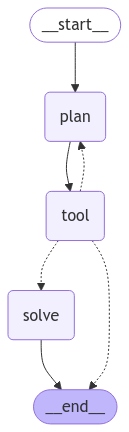

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass